# Modelling

<img src="figures/data-science-model.png" width="500px" heigth="500px">

*What is modelling?*

A statistical model is a mathematical model (i.e., a description of a system or process expressed in mathematical terms), typically specified as a relationship between input variables (or independent variables) and an output (dependent) variable. Given a model or a family of models, data are used to find good configurations of it via fitting (i.e., ending with a configuration such that the output variable is predicted well from the input variables).

*Why modelling?*

Statistical models are used for:
* Prediction: based on past data, we fit a model, which we use to predict on future data. 
* Inspection (or information): we use some data to fit a model and inspect it, in order to understand how different variables interact and contribute to the prediction of the output.

Note that predictive or data-driven modelling (the realm of statistics and machine learning), which attempts to summarize or describe the data, is not the only way to model. Theory-driven modelling can be used instead, by formalizing a certain understanding of a system into theory taking mathematical form, such as we do in physics.

For more see:
* https://hdsr.mitpress.mit.edu/pub/9qsbf3hz
* http://www2.math.uu.se/~thulin/mm/breiman.pdf

Our working definition: *"The goal of a model is to provide a simple low-dimensional summary of a dataset. Ideally, the model will capture true “signals” (i.e. patterns generated by the phenomenon of interest), and ignore “noise” (i.e. random variation that you’re not interested in)."*  https://r4ds.had.co.nz/model-intro.html

Topics:
1. Linear regression (the model)
2. Feature selection
3. Fitting
4. Evaluation
5. Logistic regression (classification)

In [1]:
# imports

import os, codecs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Import the dataset
Let us import the Venetian apprenticeship contracts dataset in memory.

In [2]:
root_folder = "../data/apprenticeship_venice/"
df_contracts = pd.read_csv(codecs.open(os.path.join(root_folder,"professions_data.csv"), encoding="utf8"), sep=";")

Let's take another look to the dataset.

In [3]:
df_contracts.head(5)

,page_title,register,annual_salary,a_profession,profession_code_strict,profession_code_gen,profession_cat,corporation,keep_profession_a,complete_profession_a,...,personal_care_master,clothes_master,generic_expenses_master,salary_in_kind_master,pledge_goods_master,pledge_money_master,salary_master,female_guarantor,period_cat,incremental_salary
0,Carlo Della sosta (Orese) 1592-08-03,"asv, giustizia vecchia, accordi dei garzoni, 1...",NaN,orese,orese,orefice,orefice,Oresi,1,1,...,1,1,1,0,0,0,0,0,NaN,0
1,Antonio quondam Andrea (squerariol) 1583-01-09,"asv, giustizia vecchia, accordi dei garzoni, 1...",12.5,squerariol,squerariol,lavori allo squero,lavori allo squero,Squerarioli,1,1,...,0,0,1,0,0,0,1,0,1.0,0
2,Cristofollo di Zuane (batioro in carta) 1591-0...,"asv, giustizia vecchia, accordi dei garzoni, 1...",NaN,batioro,batioro,battioro,fabbricatore di foglie/fili/cordelle d'oro o a...,Battioro,1,1,...,0,0,0,0,0,0,0,0,NaN,0
3,Illeggibile (marzer) 1584-06-21,"asv, giustizia vecchia, accordi dei garzoni, 1...",NaN,marzer,marzer,marzer,merciaio,Merzeri,1,1,...,0,0,0,0,0,0,0,0,NaN,0
4,Domenico Morebetti (spechier) 1664-09-13,"asv, giustizia vecchia, accordi dei garzoni, 1...",7.0,marzer,marzer,marzer,merciaio,Merzeri,1,1,...,0,0,1,0,0,0,1,0,1.0,0


In [4]:
df_contracts.columns

Index(['page_title', 'register', 'annual_salary', 'a_profession',
       'profession_code_strict', 'profession_code_gen', 'profession_cat',
       'corporation', 'keep_profession_a', 'complete_profession_a',
       'enrolmentY', 'enrolmentM', 'startY', 'startM', 'length', 'has_fled',
       'm_profession', 'm_profession_code_strict', 'm_profession_code_gen',
       'm_profession_cat', 'm_corporation', 'keep_profession_m',
       'complete_profession_m', 'm_gender', 'm_name', 'm_surname',
       'm_patronimic', 'm_atelier', 'm_coords', 'a_name', 'a_age', 'a_gender',
       'a_geo_origins', 'a_geo_origins_std', 'a_coords', 'a_quondam',
       'accommodation_master', 'personal_care_master', 'clothes_master',
       'generic_expenses_master', 'salary_in_kind_master',
       'pledge_goods_master', 'pledge_money_master', 'salary_master',
       'female_guarantor', 'period_cat', 'incremental_salary'],
      dtype='object')

Every row represents an apprenticeship contract. Contracts were registered both at the guild's and at a public office. This is a sample of contracts from a much larger set of records.

Some of the variables we will work with are:
* `annual_salary`: the annual salary paid to the apprencice, if any (in Venetian ducats).
* `a_profession` to `corporation`: increasingly generic classifications for the apprentice's stated profession.
* `startY` and `enrolmentY`: contract start and registration year respectively.
* `length`: of the contract, in years.
* `m_gender` and `a_gender`: of master and apprentice respectively.
* `a_age`: age of the apprentice at entry, in years.
* `female_guarantor`: if at least one of the contract's guarantors was female, boolean.

## Linear regression

* **Regression**: predict real/continuous values given inputs (e.g., a salary of 2.15 ducats a year).
* **Classification**: predict categorical values given inputs (e.g., there is a female guarantor in the contract or not).

--> *Whiteboard*

Model:

$y = \beta_0 + \sum_{j=1}^{d}\beta_j x_j + \epsilon$

Closed-form solution:

$\hat{\beta} = \Big(X^TX\Big)^{-1}X^Ty$

$\hat{y} = x\hat{\beta}$

In [5]:
# Let's start with a toy example

mean = [0, 0] # means (centers of mass)
cov = [[5, 0], [120, 100]]  # covariance

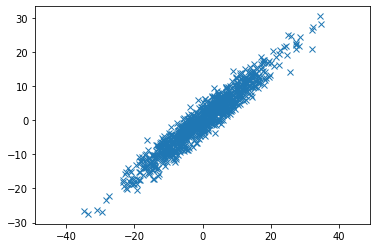

In [15]:
import matplotlib.pyplot as plt
x, y = np.random.multivariate_normal(mean, cov, 1000, check_valid='ignore').T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [7]:
# Let's fit a linear model to the data at hand

beta = 1/(np.dot(x.T,x)) * np.dot(x.T,y)

In [8]:
beta # in this 2d example this is the slope of the line!

0.8128218883709407

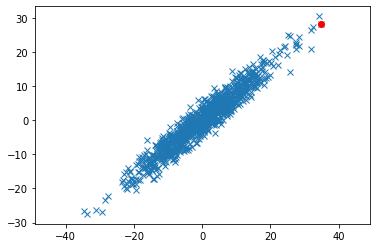

In [17]:
new_point = 35
y_hat = beta * new_point
plt.plot(x, y, 'x')
plt.plot(new_point, y_hat, 'o', c='red')
plt.axis('equal')
plt.show()

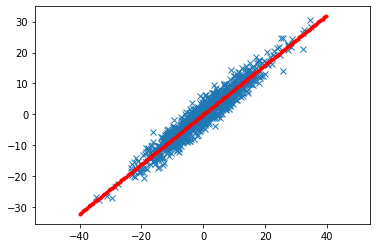

In [18]:
new_points = np.arange(-40,40,0.5)
predictions = beta * new_points
plt.plot(x, y, 'x')
plt.plot(new_points, predictions, '.', c='red')
plt.axis('equal')
plt.show()

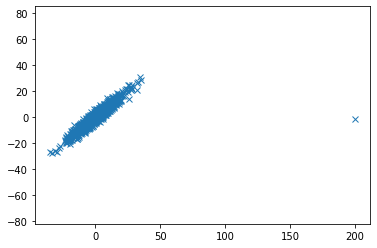

In [20]:
# Let's add an outlier!
# an anomalie

x[0] = 200
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [12]:
# Let's fit a linear model to the data again

beta = 1/(np.dot(x.T,x)) * np.dot(x.T,y)

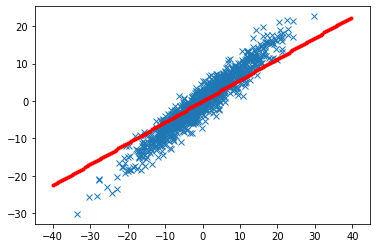

In [13]:
new_points = np.arange(-40,40,0.5)
predictions = beta * new_points
plt.plot(x, y, 'x')
plt.plot(new_points, predictions, '.', c='red')
plt.axis('equal')
plt.xlim((-40,40))
plt.show()

In [14]:
# An example with the intercept

mean = [0, 15] # means (centers of mass)
cov = [[5, 0], [120, 100]]  # covariance

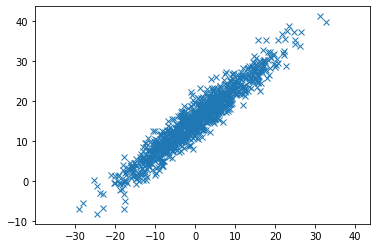

In [15]:
x, y = np.random.multivariate_normal(mean, cov, 1000, check_valid='ignore').T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [16]:
# Let's fit a linear model to the data at hand

beta = 1/(np.dot(x.T,x)) * np.dot(x.T,y)

In [17]:
beta

0.8132595665874635

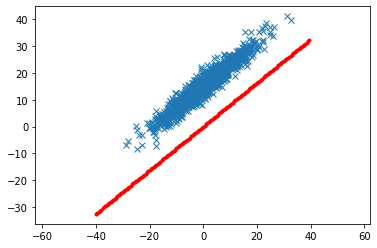

In [18]:
new_points = np.arange(-40,40,0.5)
predictions = beta * new_points
plt.plot(x, y, 'x')
plt.plot(new_points, predictions, '.', c='red')
plt.axis('equal')
plt.show()

This does not work any longer, as the default intercept is at 0,0. We need to fit for the intercept as well as for the slope.

In [19]:
# Let's use a trick and add a new column to x, all to 1: this will allow us to fit for the intercept as well

X = np.matrix([np.ones(x.shape[0]),x]).T

In [20]:
print(X.shape)
print(X[:10,:])

(1000, 2)
[[  1.          20.73998802]
 [  1.           4.06088503]
 [  1.          -4.93940172]
 [  1.           0.71438291]
 [  1.          -3.79911562]
 [  1.           9.65086242]
 [  1.           3.62750382]
 [  1.           0.23270681]
 [  1.         -17.56021405]
 [  1.          -0.51597697]]


In [21]:
# This is the same, but we need a little bit more machinery to deal with matrices

betas = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,y).T)

In [22]:
betas

matrix([[15.09564833],
        [ 0.80305349]])

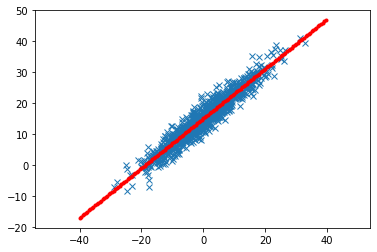

In [23]:
new_points = np.arange(-40,40,0.5)
predictions = betas[1,0] * new_points
plt.plot(x, y, 'x')
plt.plot(new_points, betas[0,0] + predictions, '.', c='red')
plt.axis('equal')
plt.show()

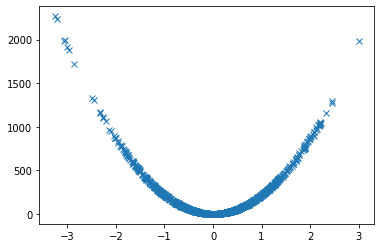

In [24]:
# Consider the following dataset (for questions)
from sklearn.datasets import make_regression # a simpler way to create regression data
x, y = make_regression(n_samples=1000, n_features=1, noise=0.2)
y = np.power(y,2)
plt.plot(x, y, 'x')
plt.show()

#### Questions

* What is the problem of applying linear regression to this dataset?
* Try that out.
* Can you think of a solution, still using linear regression?

### Feature selection

Let us focus on our regression task: predicting the salary of an apprentice given some other features of the contract. We need to select and inspect the variables to use, forming up our domain-specific model. The choice of the features, eventually their filtering and transformations, should be informed by our working hypothesis.

In [25]:
print(df_contracts.shape[0])

# select a few independent variables and drop NA
df_dataset = df_contracts[["annual_salary","length","a_age","female_guarantor","salary_master","incremental_salary"]].dropna()
# only pick contracts with a salary paid by the master to the apprentice
df_dataset = df_dataset[df_dataset.salary_master == 1]
print(df_dataset.shape[0])
df_dataset = df_dataset.drop("salary_master",axis=1)

9653
7258


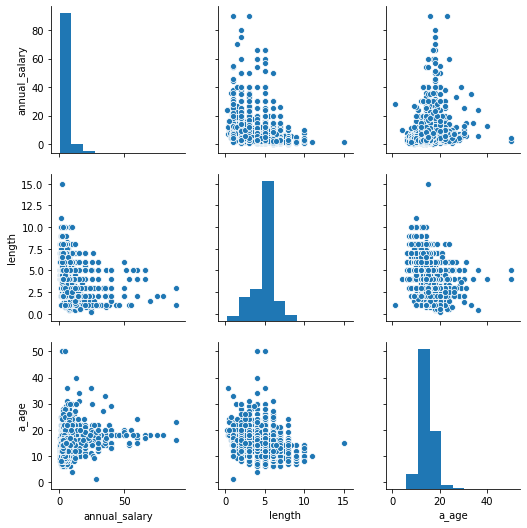

In [26]:
# watch for correlations, but be wary of very high correlations: they might signal data leackage on the dependent variable!

sns.pairplot(df_dataset[["annual_salary","length","a_age"]])

### Fitting

Usually we do not use the closed-form solution to fit a model. We instead rely on existing packages which offer approximate and robust methods to fit a model. There is quite much more to even linear regression than what we were able to touch upon, thus it is often a good idea, once the basics are clear, to turn to a more robust implementation.

In [27]:
import statsmodels.api as sm

In [29]:
# Add intercept

y = df_dataset[["annual_salary"]]
#you remove because you can not use the output to do prediction
X = df_dataset.drop("annual_salary",axis=1)
X = sm.add_constant(X, prepend=False)

In [30]:
y.shape

(7258, 1)

In [31]:
X.shape

(7258, 5)

In [32]:
# Fit model

mod = sm.OLS(y, X)
res = mod.fit()

In [33]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          annual_salary   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     443.0
Date:                Thu, 25 Jul 2019   Prob (F-statistic):               0.00
Time:                        18:00:22   Log-Likelihood:                -21368.
No. Observations:                7258   AIC:                         4.275e+04
Df Residuals:                    7253   BIC:                         4.278e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
length                -1.3712      0

In [ ]:
y annual salry = 9.44(const) + (-1.37 lenght) + (0.18age) + (-0.08 FG) + (4.13 increemntal salary)

#one year your work lost -1.3
#one year more apprenty 0.18

#from const 9.44

#you need stress test to validate this model 
#good to read book 

## Logistic regression

* **Regression**: predict real/continuous values given inputs (e.g., a salary of 2.15 ducats a year).
* **Classification**: predict categorical values given inputs (e.g., there is a female guarantor in the contract or not).

--> *Whiteboard*

Model:

$\hat{y} = \frac{1}{1 + e^{-\big(\beta_0 + \sum_{j=1}^{d}\beta_j x_j + \epsilon \big)}}$

In [46]:
# shape of a sigmoid function
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

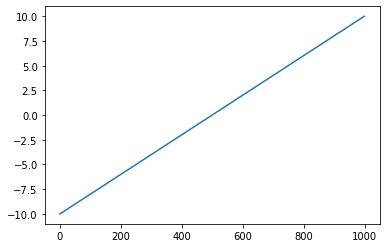

In [47]:
plt.plot(np.linspace(-10,10,1000))

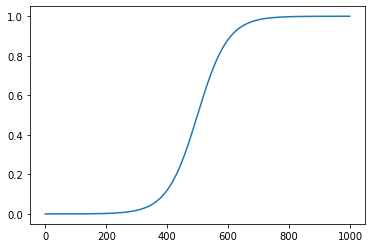

In [48]:
plt.plot([sigmoid(x) for x in np.linspace(-10,10,1000)])

In [49]:
# Let's start again with a toy example

from sklearn.datasets import make_classification # a simpler way to create classification data
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
                           random_state=0, n_clusters_per_class=1)

In [50]:
X.shape

(1000, 2)

In [51]:
np.unique(y)

array([0, 1])

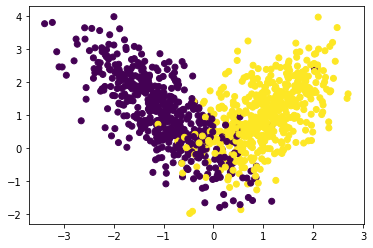

In [52]:
plt.scatter(X[:,0], X[:,1], c=y)

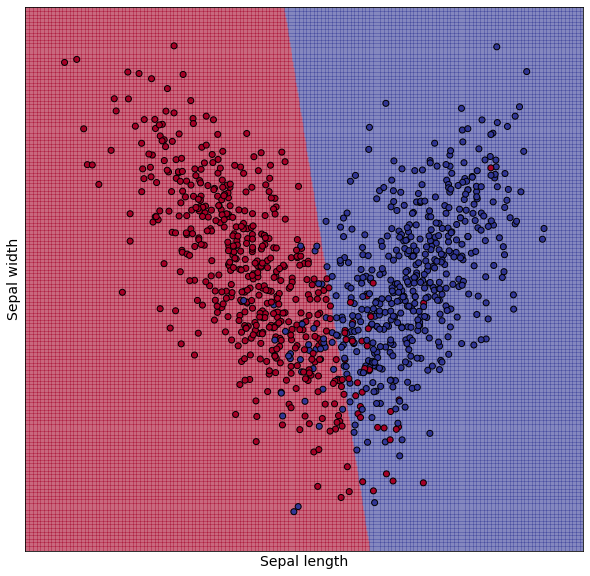

In [53]:
# From: https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#sphx-glr-auto-examples-linear-model-plot-iris-logistic-py

from sklearn.linear_model import LogisticRegression

#API three methods
# fitting
#transforming
#prediction


logreg = LogisticRegression(solver='lbfgs')

# Create an instance of Logistic Regression Classifier and fit the data.
# FITTING
logreg.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(10, 10))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.2)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdYlBu)
plt.xlabel('Sepal length', fontsize=14)
plt.ylabel('Sepal width', fontsize=14)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

#decision of boundraries of the model


### A real example: Tesla vs SpaceX tweets

In [54]:
import spacy
import nltk
import string
import sklearn

In [55]:
# load the dataset

root_folder = "../data/musk_tweets"
df_elon = pd.read_csv(codecs.open(os.path.join(root_folder,"df_elon.csv"), encoding="utf8"), sep=",")

In [56]:
df_elon.head(5)

# here we have only tweet not classification

,id,created_at,text,clean_text
0,849636868052275200,2017-04-05 14:56:29,'And so the robots spared humanity ... https:/...,robots spared humanity
1,848988730585096192,2017-04-03 20:01:01,"""@ForIn2020 @waltmossberg @mims @defcon_5 Exac...",@ForIn2020 @waltmossberg @mims @defcon_5 Exact...
2,848943072423497728,2017-04-03 16:59:35,"'@waltmossberg @mims @defcon_5 Et tu, Walt?'",@waltmossberg @mims @defcon_5 Walt
3,848935705057280001,2017-04-03 16:30:19,'Stormy weather in Shortville ...',Stormy weather Shortville
4,848416049573658624,2017-04-02 06:05:23,"""@DaveLeeBBC @verge Coal is dying due to nat g...",@DaveLeeBBC @verge Coal dying fracking It's ba...


In [57]:
# Filter to just Tesla or SpaceX
# create classifier

def classify_t_or_s(tweet):
    
    if type(tweet) == str and "@SpaceX" in tweet:
        return 1
    elif type(tweet) == str and "@TeslaMotors" in tweet:
        return 0
    return -1

def remove_t_or_s(tweet):
    
    if type(tweet) == str:
        removed = tweet.replace("@SpaceX","")
        removed = removed.replace("@TeslaMotors","")
        return removed
    return ""

In [58]:
# Create classes and remove the discriminant token!
df_elon["class"] = df_elon["clean_text"].apply(classify_t_or_s)
df_elon["clean_text_rm"] = df_elon["clean_text"].apply(remove_t_or_s)

In [59]:
df_elon.head(5)

df_elon[df_elon["class"]== 1].head(5)

#interested by class 1 @SpaceX
# @TeslaMotors class 0

,id,created_at,text,clean_text,class,clean_text_rm
11,848239664536223745,2017-04-01 18:24:30,'RT @ProfBrianCox: This is extremely important...,@ProfBrianCox This extremely important from @e...,1,@ProfBrianCox This extremely important from @e...
22,847610880506208257,2017-03-31 00:45:56,'RT @SpaceX: More photos from today\xe2\x80\x9...,@SpaceX More photos from today x99s Falcon lau...,1,More photos from today x99s Falcon launch fir...
23,847608431582208000,2017-03-31 00:36:12,'@BadAstronomer @SpaceX Thanks Phil!',@BadAstronomer @SpaceX Thanks Phil,1,@BadAstronomer Thanks Phil
25,847580067446345728,2017-03-30 22:43:30,'RT @SpaceX: Falcon 9 first stage has landed o...,@SpaceX Falcon first stage landed Course Still...,1,Falcon first stage landed Course Still Love w...
26,847561780532523008,2017-03-30 21:30:50,'RT @SpaceX: ~60 minutes until launch window f...,@SpaceX minutes until launch window opens syst...,1,minutes until launch window opens systems wea...


In [60]:
df_reduced = df_elon[df_elon["class"] != -1]
df_reduced.shape

(316, 6)

In [60]:
# let's create the TF-IDF representation of the dataset

from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=False)

#TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
count_vect = TfidfVectorizer(tokenizer=tknzr.tokenize)
X = count_vect.fit_transform(df_reduced.clean_text_rm)
X.shape

(316, 1330)

In [61]:
#CountVectorizer
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=False)
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(tokenizer=tknzr.tokenize)
X = count_vect.fit_transform(df_reduced.clean_text_rm)
X.shape

(316, 1330)

In [62]:
y = df_reduced["class"].values

In [63]:
logreg = LogisticRegression(solver='lbfgs')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
# Try it out

test_tweet1 = "Let's all go to Mars and colonize!"
test_tweet2 = "Let's all go to Mars on an electric car with auto pilot"
x = count_vect.transform([test_tweet1])
print(logreg.predict(x)[0])
print(logreg.predict_proba(x)[0])

#output of the trheshold model

#confident at 39% that tweet2 is class 1 :  @SpaceX

1
[0.39710206 0.60289794]


In [65]:
# Try it out

test_tweet1 = "Let's all go to Mars and colonize!"
test_tweet2 = "Let's all go to Mars on an electric car with auto pilot"
x = count_vect.transform([test_tweet2])
print(logreg.predict(x)[0])
print(logreg.predict_proba(x)[0])

#confident at 46% that tweet2 is class 1 :  @SpaceX

1
[0.4681267 0.5318733]


*But, does it actually work?*

In [66]:
# Try it out

test_tweet1 = "Let's all go to Mars and colonize!"
test_tweet2 = "Let's all go with an electric car with auto pilot"
x = count_vect.transform([test_tweet2])
print(logreg.predict(x)[0])
print(logreg.predict_proba(x)[0])

#confident at 72% that tweet2 is class 0 :  @TeslaMotors

0
[0.72029129 0.27970871]


### Evaluation

#### Exploratory vs confirmatory modelling

"Traditionally, the focus of modelling is on *inference, or for confirming that an hypothesis is "true"*. Doing this correctly is not complicated, but it is hard. There is a pair of ideas that you must understand in order to do inference correctly:

* Each observation can either be used for exploration or confirmation, not both.

* You can use an observation as many times as you like for exploration, but you can only use it once for confirmation. As soon as you use an observation twice, you’ve switched from confirmation to exploration.

This is necessary because to confirm a hypothesis you must use data independent of the data that you used to generate the hypothesis. Otherwise you will be over optimistic. There is absolutely nothing wrong with exploration, but you should never sell an exploratory analysis as a confirmatory analysis because it is fundamentally misleading.

If you are serious about doing an confirmatory analysis, one approach is to split your data into three pieces before you begin the analysis:

* 60% of your data goes into a **training** (or exploration) set. You’re allowed to do anything you like with this data: visualise it and fit tons of models to it.

* 20% goes into a **validation** set. You can use this data to compare models or visualisations by hand, but you’re not allowed to use it as part of an automated process.

* 20% is held back for a **test** set. You can only use this data ONCE, to test your final model.

This partitioning allows you to explore the training data, occasionally generating candidate hypotheses that you check with the query set. When you are confident you have the right model, you can check it once with the test data."

https://r4ds.had.co.nz/model-intro.html

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

In [65]:
logreg.fit(X_train, y_train)
y_hat_test = logreg.predict(X_test)

# evaluate using accuracy: proportion of correctly predicted over total
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_hat_test))
print(accuracy_score(y_test, y_hat_test, normalize=False))

0.7789473684210526
74


We are doing well already! Try to play with the model or with the pre-processing and test against the test set. When you are happy, do a final evaluation against the validation set.

#### Questions

* Read about precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall. Add them to the evaluation above. Hint: see the `precision_score` and `recall_score` here: https://scikit-learn.org/stable/modules/model_evaluation.html.
* Build a multiclass logistic classifier for the BL book genre (perhaps during the afternoon session).